# Poisson Image Editing

[Poisson equation](https://en.wikipedia.org/wiki/Discrete_Poisson_equation) is one of the most important partial differential equations in numerical analysis having numerous applications in several discplines. An application of Poisson equation in image analysis is [image blending/image editing](https://www.ipol.im/pub/art/2016/163/article_lr.pdf). Also look at the original work [here](https://www.cs.jhu.edu/~misha/Fall07/Papers/Perez03.pdf).

### Only change the cells where you are instructed to do so. Leave all other cells unchanged.

In this notebook, first you will look at a sparse linear matrix solver method to solve the problem. The you will implement (1) an iterative method and a (2) Fourier transform-based method. The source code, notebook images and the problem description have been adopted from [here](https://github.com/PPPW/poisson-image-editing/blob/master/poisson_image_editing.ipynb).


Our goal is to extract the Statue of Liberty from this source image:

<img src="source1.jpg" alt="Source" width="200"/>

and merge it with the target image:

<img src="target1.jpg" alt="Target" width="200"/>

The mask image:

<img src="mask1.png" alt="Mask" width="200"/>

is used to extract the Statue of Liberty part out from `source1.jpg`. This mask is a black and white image. When we apply it to `source1.jpg`, we'll filter out everything except for the Statue of Liberty and a little bit surrounding area. If we paste the extracted part directly to our target image, then we'll get:

<img src="direct_merge1.png" alt="Paste" width="200"/>

So, the copy-paste result is not that great.

Poisson image editing (PIE) method provides a much better alternative. In PIE only the source gradient information is copied and using this gradient information the rest of the maked area is filled in using color from the target image. This is done by solving Poisson equation.

More specifically, Eq. (10) in [Pérez 2003](https://www.cs.jhu.edu/~misha/Fall07/Papers/Perez03.pdf) is used here for seamless cloning. Let $\mathbf{f}$ be the pixel values in the region to paste (which is what we're trying to solve), let $\mathbf{g}$ be the corresponding region in the source image. Instead of letting $\mathbf{f}=\mathbf{g}$, we let $\nabla \mathbf{f} = \nabla \mathbf{g}$, and let the pixel values on the boundary to be the same as those from the target image. In this way, the pixel values $\mathbf{f}$'s distribution is "guided" by the source image, and gradually blends to the target image on the boundary. More rigorous derivations can be found in [Pérez 2003](https://www.cs.jhu.edu/~misha/Fall07/Papers/Perez03.pdf), the main idea is to let the pixel values be the same on the boundary, and find a distribution that resembles the source image and changes to the target image smoothly.  

The only technical difficulty is to implement the Laplacian operator. [This](https://en.wikipedia.org/wiki/Discrete_Poisson_equation) is a good reference. We first build the matrix $\mathbf{D}$, then build matrix $\mathbf{A}$ by setting $\mathbf{D}$ as block diagonal element, and set the $\mathbf{I}$'s:


In [ ]:
# Do not edit this cell
import scipy.sparse

def laplacian_matrix(n, m):
    mat_D = scipy.sparse.lil_matrix((m, m))
    mat_D.setdiag(1, -1)
    mat_D.setdiag(-4)
    mat_D.setdiag(1, 1)

    mat_A = scipy.sparse.block_diag([mat_D] * n).tolil()

    mat_A.setdiag(1, 1*m)
    mat_A.setdiag(1, -1*m)

    return mat_A

laplacian_matrix(3, 3).todense()

matrix([[-4.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 1., -4.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -4.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0., -4.,  1.,  0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  1., -4.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  1., -4.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.,  0., -4.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  1., -4.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1., -4.]])

Now our equation becomes:    
$\mathbf{Af} = \mathbf{Ag}$, inside the region;    
$\mathbf{f} = \mathbf{t}$, outside the region.

where $\mathbf{g}$ is the pixel value of the source image, $\mathbf{t}$ is the pixel value of the target image.

Now we are ready to implement our Poisson editting algorithm. First, we load the images and the masks:

Source image size: (388, 600)


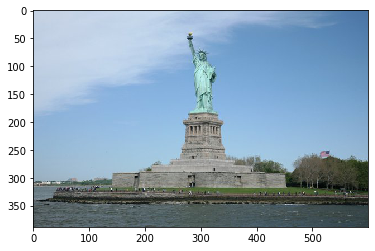

Target image size: (450, 600)


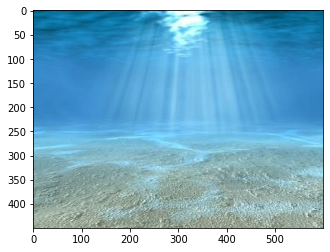

Mask size: (450, 600)


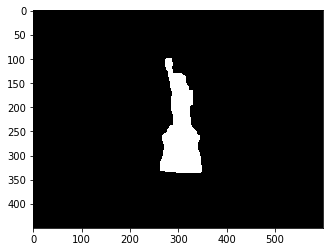

In [ ]:
# Do not edit this cell

from os import path
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as tf
from scipy.fftpack import fft2,ifft2,dst,idst

%matplotlib inline

source = io.imread("source1.jpg")
target = io.imread("target1.jpg")
mask = io.imread("mask1.png",as_gray=True)

offset = (0, 66)

print('Source image size:', source.shape[:-1])
plt.imshow(source) # this is a trick to display the image in here
plt.show()
print('Target image size:', target.shape[:-1])
plt.imshow(target)
plt.show()
print('Mask size:', mask.shape)
plt.imshow(mask, cmap='gray')
plt.show()

Note the mask tells us what region to extract from the source image, when we insert to the target image, we may want to translate it, so we need an offset parameter. In here, I set the offset value directly, I'll talk about how to find the desired value later.

Now we translate the source image according to the offset:

Source image size: (450, 600)


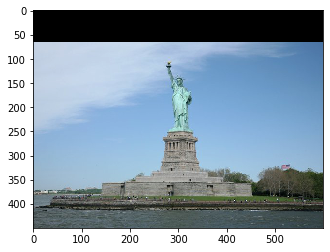

In [ ]:
# Do not edit this cell

y_max, x_max = target.shape[:-1]
y_min, x_min = 0, 0
x_range = x_max - x_min
y_range = y_max - y_min

M = np.float32([[1, 0, offset[0]], [0, 1, -offset[1]], [0, 0, 1]])
tform = tf.AffineTransform(matrix=M)

source = tf.warp(source, tform, output_shape=target.shape[:-1])

print('Source image size:', source.shape[:-1])
plt.imshow(source)
plt.show()

Convert the mask's value to {0, 1} (it was {0, 255}):

In [ ]:
# Do not edit this cell

mask = mask[y_min:y_max, x_min:x_max]
mask[mask != 0] = 1

Now we need to generate the matrix $\mathbf{A}$. First, apply our function to get the Laplacian matrix:

In [ ]:
# Do not edit this cell

mat_A = laplacian_matrix(y_range, x_range)
laplacian = mat_A.tocsc()

We only want to apply the Laplacian operator inside the blending region, so for the outside part, we set it to identity. Note for each row in mat_A, if it takes the Laplacian, then the row will have a "4" on the diagonal and four "-1", so to set it to identity, we want to set the "4" to "1", and the rest to "0":

In [ ]:
# Do not edit this cell

for y in range(1, y_range - 1):
    for x in range(1, x_range - 1):
        if mask[y, x] == 0:
            k = x + y * x_range
            mat_A[k, k] = 1
            mat_A[k, k + 1] = 0
            mat_A[k, k - 1] = 0
            mat_A[k, k + x_range] = 0
            mat_A[k, k - x_range] = 0
mat_A = mat_A.tocsc()

Now

In [ ]:
# Do not edit this cell

from scipy.sparse.linalg import spsolve

output_spsolve = target.copy()

mask_flat = mask.flatten()
for channel in range(source.shape[2]):
    source_flat = source[y_min:y_max, x_min:x_max, channel].flatten()
    target_flat = target[y_min:y_max, x_min:x_max, channel].flatten()

    # inside the mask:
    # \Delta f = div v = \Delta g
    alpha = 200.0
    mat_b = laplacian.dot(source_flat)*alpha

    # outside the mask:
    # f = t
    mat_b[mask_flat == 0] = target_flat[mask_flat == 0]

    x = spsolve(mat_A, mat_b)
    x = x.reshape((y_range, x_range))
    x[x > 255] = 255
    x[x < 0] = 0
    x = x.astype('uint8')

    output_spsolve[y_min:y_max, x_min:x_max, channel] = x

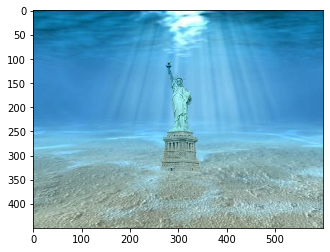

In [ ]:
# Do not edit this cell

plt.imshow(output_spsolve)
plt.show()


## Iterative solver

### Weight 15%

Now you are going to implement an iterative solution method for Poisson. An iterative solution is slow, but is often the easiest to implement. In the following cell implement the iterative scheme below:

$u_{i,j} \leftarrow u_{i,j} + \delta t (-4u_{i,j}+u_{i+1,j}+u_{i,j+1}+u_{i-1,j}+u_{i,j-1}-b_{i,j}),$

$(i,j)$ is a pixel location, $\delta t$ is a timestep (aka learning rate). A $\delta t$ value greater than $0.25$ will not let the scheme converge. Taking $\delta t=0.25$, the above equation becomes [Jacobi iterations](https://crunchingnumbers.live/2017/07/09/iterative-methods-part-2/):

$u_{i,j} \leftarrow \frac{1}{4}(u_{i+1,j}+u_{i,j+1}+u_{i-1,j}+u_{i,j-1}-b_{i,j}),$


Compute $b_{i,j}$ as follows:

$b_{i,j} = \alpha \Delta (S_{i,j})M_{i,j} + \Delta (T_{i,j})(1-M_{i,j}),$

where $\alpha$ is the blending constant. $S,T,M$ respectively denote the source, the target and the mask image. $\Delta (A)$ denote the Laplacian of an image $A$. Use the supplied "my_laplacian" function to compute Laplacian.

Initialize $u$ to the target image $T$. Note that the above iterative scheme should be run for all the interior pixel locations $(i,j)$. You can take one pixel-thick border here.

#### Your iterative implementation should use only a single for loop for the number of iterations. Set the number of iterations by trial and error. For pixel indexing use vector indexing with colon notations or any other means.

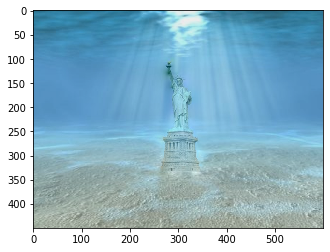

In [ ]:
# Do not edit any portion of this cell except where you are instructed to do so

def my_laplacian(I,h,w):
    IL = np.zeros((h,w))
    IL[1:h-1,1:w-1] = (-4.0*I[1:h-1,1:w-1] + I[0:h-2,1:w-1] + I[2:h,1:w-1]
                                           + I[1:h-1,0:w-2] + I[1:h-1,2:w])
    return IL

h = target.shape[0]
w = target.shape[1]

Laplacian = np.zeros((h,w,3))

for c in range(3):
    Laplacian[:,:,c] = (alpha*my_laplacian(source[:,:,c],h,w)*mask +
                                   my_laplacian(target[:,:,c],h,w)*(1.-mask))

output_itr = target.copy()
output_itr = output_itr.astype('float64')

# write your code below that implements the Jacobi iteration - use only one for loop


# Do not edit the code below
output_itr = 255.0*(output_itr-np.amin(output_itr))/(np.amax(output_itr)-np.amin(output_itr))
output_itr = output_itr.astype('uint8')

plt.imshow(output_itr)
plt.show()

## Frequency domain Poisson Image Editing - Method I

### Weight 25%

While iterative method is a classical way to solve Poisson equation. It is slow. On the other hand, sparse matrix method is fast, but it does not scale well for 3D data.

So, you will try yet another method to solve PIE. Some methods are based on Fourier transfom, e.g., [this one](https://arxiv.org/abs/1902.00176). These methods are fast, scale very well to 3D, but may not be as accurate when dealing with boundary conditions.

You will implement only a part of the algorithm mentioned in the above paper.

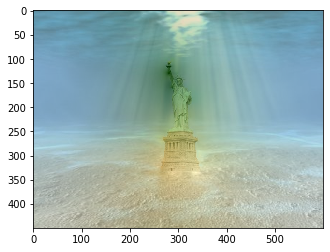

In [ ]:
# Do not edit any portion of this cell except where you are instructed to do so

pad = 4

sourceP = np.pad(source,((pad,pad),(pad,pad),(0,0)),'edge')
targetP = np.pad(target,((pad,pad),(pad,pad),(0,0)),'maximum')
maskP = np.pad(mask,((pad,pad),(pad,pad)),'edge')

hP = targetP.shape[0]
wP = targetP.shape[1]

LaplacianP = np.zeros((hP,wP,3))

for c in range(3):
    LaplacianP[:,:,c] = (alpha*my_laplacian(sourceP[:,:,c],hP,wP)*maskP +
                                   my_laplacian(targetP[:,:,c],hP,wP)*(1.-maskP))

# Write your code using the following steps
# Step 1: define dirac matrix of appropriate size
# Step 2: define Laplacian matrx of the same size
# Step 3: Compute Green's function as a ratio of FFT2 of dirac matrix
#         over FFt2 of Laplacian matrix. Make sure to avoid division by zero.
# Step 4: Initialze "output_fft = np.zeros((hP,wP,3))"
# Step 5: Compute output_fft for 3 channels using "Algorithm B" in the paper

# Implement the above steps below

# Do not edit the code below (this is part of Algoritm B of the paper)
output_fft = output_fft-output_fft[0,0,:]
output_fft = output_fft[pad:-pad,pad:-pad,:]

output_fft = 255.0*(output_fft-np.amin(output_fft))/(np.amax(output_fft)-np.amin(output_fft))
output_fft = output_fft.astype('uint8')

plt.imshow(output_fft)
plt.show()

## Frequency domain Poisson Image Editing - Method II

### Weight 25%

You will implement yet another frequency domain method to solve PIE. This method is based on [discrete sine transform](https://en.wikipedia.org/wiki/Discrete_sine_transform). You will implement only a tiny part of Code A from [this material](https://web.media.mit.edu/~raskar/photo/code.pdf). There was an entire [workshop in ICCV 2007](http://www.amitkagrawal.com/ICCV2007Course/) dedicated to gradient domain image manipulations.

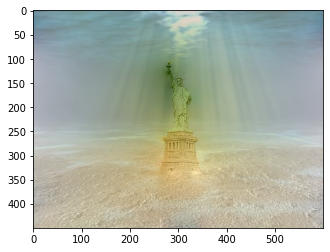

In [ ]:
# Implement the following steps to implement discrete sine transform-based PIE
# Step 1: compute eigen values as shown inside Code A
# Step 2: Compute "output_dst" using data "LaplacianP" from the previous cell and the eigen
#         values you computed in step 1. Use dst and idst appropriately.

# Write your code below for the above steps

# Do not edit the code below
output_dst = output_dst[pad:-pad,pad:-pad,:]

output_dst = 255.0*(output_dst - np.amin(output_dst))/(np.amax(output_dst) - np.amin(output_dst))
output_dst = output_dst.astype('uint8')

plt.imshow(output_dst)
plt.show()

## Color Correction

### Weight 35%

You must have noticed that the output images from frequency-domain methods have distorted color. So the frequency-based methods are not as accurate as the sparse solver method. One effective way to fix the color distortion is to implement [histogram matching](https://en.wikipedia.org/wiki/Histogram_matching), which adjusts the color distribution of the output image to match that of the target image (from the sparse solver method). Histogram matching ensures that the pixel intensity distribution of the frequency-domain result closely follows that of the target image, thus reducing color distortion.


Display your post-processed image, which should appear close in color to the target image.

### Note

*   You can reuse other's code from the internet, but you must fully understand the code and provide a citation with the URL to the original source. When collaborating with others, please adhere to the Code of Student Behaviour to ensure academic integrity.

*   You are not allowed to use external libraries like skimage or opencv to perform histogram matching. Please manually implement the histogram matching algorithm from scratch. This involves calculating the histograms, generating the cumulative distribution functions (CDFs) for both images, and then mapping the pixel values of the frequency-domain result to match the target image’s color distribution.



In [ ]:
# Write your color correction code in this cell
